In [2]:
import os
import itertools
import time
import random

import numpy as np # linear algebra
from scipy import signal as sc
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score
from math import floor, ceil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import os
from math import floor, ceil
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from matplotlib import colors
import seaborn as sns
from adabelief_pytorch import AdaBelief
from termcolor import colored


/home/benx13/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CustomImageDataset(Dataset):
  def __init__(self, labels_file, img_dir, transform=None):
    self.img_labels = scipy.io.loadmat(labels_file)['code_bdh'][0]
    self.img_dir = img_dir
    self.transform = transform
    self.imgs = [img for img in os.listdir(img_dir)]
    self.imgs.sort() 

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = Image.open(self.img_dir + '/' + self.imgs[idx])
    label = self.img_labels[idx] -1
    if self.transform:
      image = self.transform(image)
    return np.array(image), label

In [4]:
transform = T.Compose([
   T.Resize((224, 224)),
   T.ToTensor()
]) 
img_dir = 'data_2021/data_2021/png'
labels_file = 'data_2021/data_2021/code_bdh.mat'

In [5]:
dataset = CustomImageDataset(labels_file, img_dir, transform=transform) 
loader = DataLoader(dataset, batch_size=1 , shuffle=True)

In [6]:
for i in loader:
    print(i[0].shape)
    break

torch.Size([1, 3, 224, 224])


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
model = torchvision.models.efficientnet_b0(pretrained=False)
model.fc = nn.Linear(512, 22)
model= nn.DataParallel(model)
model.load_state_dict(torch.load('efficientNetB0_100acc.pt'))

/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/benx13/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [9]:
model = model.module.to('cpu')

In [ ]:
model.eval()

In [11]:
activations = []
def get_activation():
    def hook(model, input, output):
        activations.append(output.detach().squeeze().numpy())
    return hook

In [12]:
model.avgpool.register_forward_hook(get_activation())

In [13]:
y = []
for i, (signal, labels) in tqdm(enumerate(loader)):
    out = model(signal)
    y+= labels.tolist()

7560it [09:45, 12.92it/s]


In [14]:
print(len(activations))

7560


In [15]:
new = np.array(activations)

In [16]:
new.shape

(7560, 1280)

In [17]:

from sklearn.decomposition import PCA


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
#PCA
from sklearn.manifold import TSNE



In [18]:
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=3000, learning_rate='auto').fit_transform(new)

/home/benx13/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


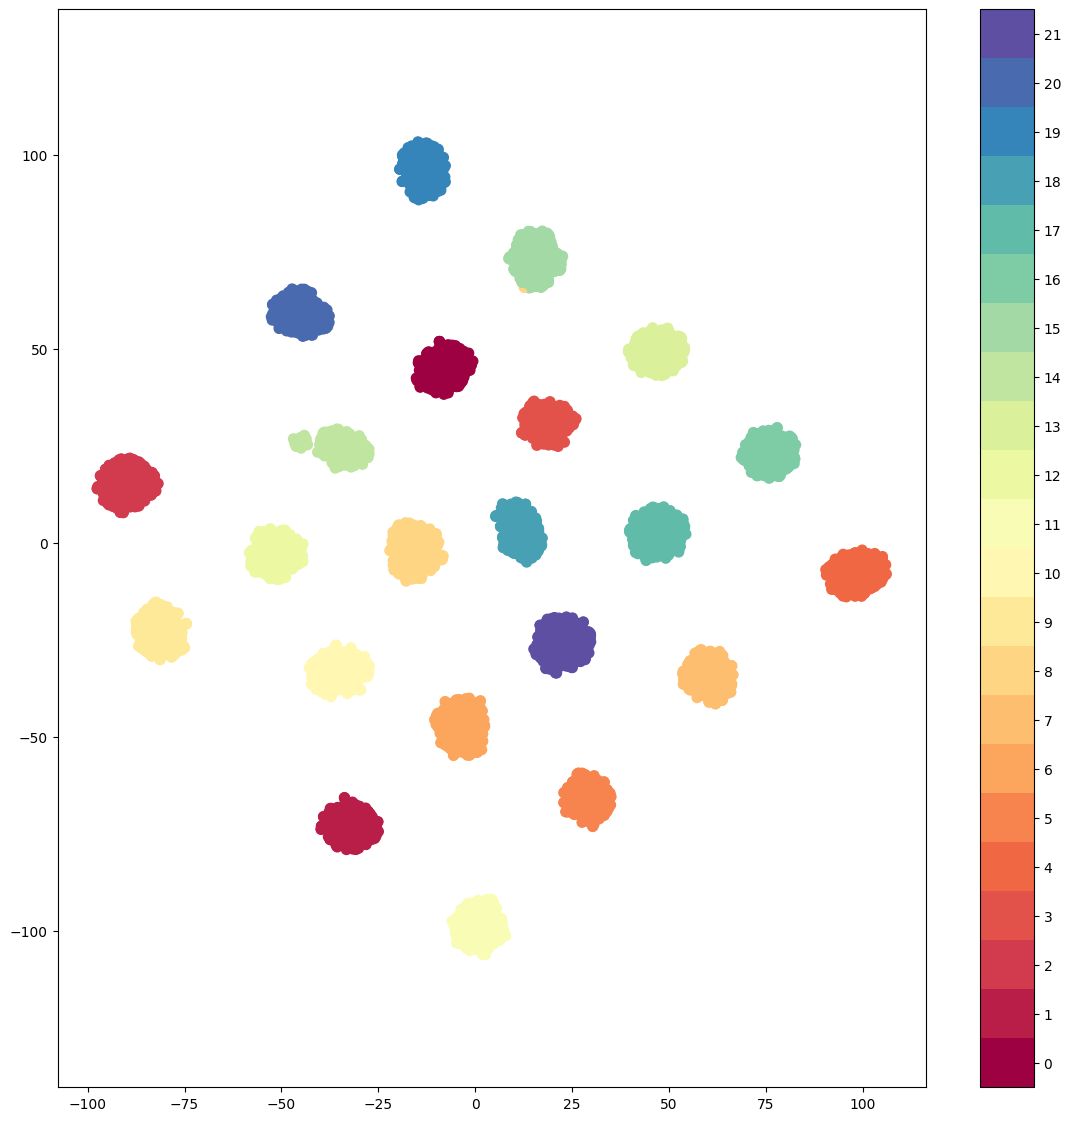

In [20]:
plt.figure(figsize=(14, 14))
plt.scatter(tsne[:,0], tsne[:,1], c=y,s=50, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(23)-0.5).set_ticks(np.arange(22))